In [26]:
# project: p6
# submitter: txiong53
# partner: none
# hours: 10

In [27]:
import geopandas as gpd
import sqlite3
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from rasterio.mask import mask
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.pipeline import Pipeline


In [28]:
#q1
# How many counties are in Wisconsin?
data = gpd.read_file("counties.geojson")
len(data)

72

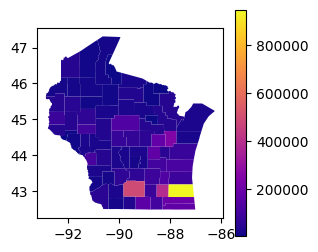

In [29]:
#q2
# What is the population of each county in WI?
ax = data.plot(column="POP100", legend=True, cmap="plasma", figsize=(3,3))
fig = ax.get_figure()
fig.set_dpi(100)

In [30]:
# Feature1 AREALAND
conn = sqlite3.connect("counties_tracts.db")
# pd.read_sql("""SELECT * FROM sqlite_master""", conn)
counties_table = pd.read_sql("""SELECT * FROM counties""", conn)
# add an AREALAND column to your GeoDataFrame
data["AREALAND"] = counties_table['AREALAND']
train, test = train_test_split(data, random_state=320, test_size=0.25)

In [31]:
#q3
# What are the counties in the test dataset?
counties_list = test['NAME'].to_list()
counties_list

['Kewaunee County',
 'Calumet County',
 'Adams County',
 'Eau Claire County',
 'Milwaukee County',
 'Ashland County',
 'Wood County',
 'Dodge County',
 'Sauk County',
 'Clark County',
 'Pepin County',
 'Taylor County',
 'Iron County',
 'Outagamie County',
 'Florence County',
 'Oneida County',
 'Pierce County',
 'Grant County']

In [32]:
#q4
# How much variance in the POP100 can a LinearRegression model explain based only on AREALAND?
model = LinearRegression()
model.fit(train[['AREALAND']], train['POP100'])
model.score(test[['AREALAND']], test['POP100'])

0.022002661530554857

In [33]:
#q5
# What is the predicted population of a county with 500 square miles of area, according to the model?
#500miles * 2.59 = 1295000000 m^2
prediction_df = pd.DataFrame({"AREALAND": [1295000000]})
prediction = model.predict(prediction_df)
prediction[0]

82032.53073541154

In [34]:
# Feature 2: HU100 (housing units)
# pd.read_sql("""SELECT * FROM sqlite_master""", conn)
tracts_table = pd.read_sql("""SELECT * FROM tracts""", conn)


counties_table.to_sql("counties", conn, if_exists="replace", index=False)
tracts_table.to_sql("tracts", conn, if_exists="replace", index=False)


sumTable = pd.read_sql("""
  SELECT COUNTY, SUM(HU100) AS HU100 FROM 
  tracts GROUP BY COUNTY""",
  conn)

sumTable.to_sql("sumtable", conn, if_exists="replace", index=False)

new = pd.read_sql("""
  SELECT * FROM 
  counties INNER JOIN sumtable 
  ON sumtable.COUNTY = counties.COUNTY """,
  conn).drop(columns="COUNTY")

new['POP100'] = data['POP100']
train2, test2 = train_test_split(new, random_state=320, test_size=0.25)


In [35]:
#q6
counties_list2 = test2['NAME'].to_list()
counties_list2

['Kewaunee County',
 'Calumet County',
 'Adams County',
 'Eau Claire County',
 'Milwaukee County',
 'Ashland County',
 'Wood County',
 'Dodge County',
 'Sauk County',
 'Clark County',
 'Pepin County',
 'Taylor County',
 'Iron County',
 'Outagamie County',
 'Florence County',
 'Oneida County',
 'Pierce County',
 'Grant County']

In [36]:
#q7
# What are the HU100 values for the counties in the train dataset?
name = train2["NAME"].to_list()
count = train2["HU100"].to_list()   

q7_dic = {name[i]: count[i] for i in range(len(name))}
q7_dic

{'Walworth County': 51531,
 'Marquette County': 9896,
 'Racine County': 82164,
 'Waupaca County': 25396,
 'Lincoln County': 16784,
 'Washburn County': 12979,
 'Door County': 23966,
 'Waukesha County': 160864,
 'Sheboygan County': 50766,
 'La Crosse County': 48402,
 'Langlade County': 12360,
 'Marathon County': 57734,
 'Jefferson County': 35147,
 'Price County': 11120,
 'Vilas County': 25116,
 'Columbia County': 26137,
 'Ozaukee County': 36267,
 'Fond du Lac County': 43910,
 'Crawford County': 8802,
 'Lafayette County': 7230,
 'Green County': 15856,
 'Marinette County': 30379,
 'Vernon County': 13720,
 'Douglas County': 22825,
 'Rock County': 68422,
 'Iowa County': 10719,
 'Dane County': 216022,
 'Bayfield County': 12999,
 'Polk County': 24248,
 'Trempealeau County': 12619,
 'Brown County': 104371,
 'Washington County': 54695,
 'Chippewa County': 27185,
 'Oconto County': 23537,
 'Richland County': 8868,
 'Portage County': 30054,
 'Sawyer County': 15975,
 'Menominee County': 2253,
 'Barr

In [37]:
#q8
# How much variance in the POP100 can a LinearRegression model explain based only on HU100?
model2 = LinearRegression()
scores = cross_val_score(model2, train2[['HU100']],train2['POP100'])
scores.mean()

0.9652534544116037

In [38]:
#q9
# What is the standard deviation of the cross validation scores from Q8?
scores.std()

0.03704265206670459

In [39]:
#q10
# What is the formula relating POP100 and HU100?
model2.fit(train2[['HU100']],train2['POP100'])
k = round(model2.coef_[0],2)
b = round(model2.intercept_,2)
q10_res = f"POP100 = {k}*HU100 + {b}"
q10_res

'POP100 = 2.39*HU100 + -7910.46'

Text(0.53, 0.51, 'Dane')

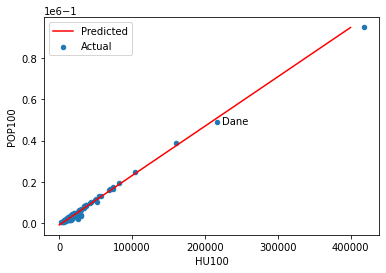

In [42]:
#q11
# What is the relationship between HU100 and POP100, visually?
prediction_df = pd.DataFrame({"HU100": [0, 100000, 200000, 300000, 400000]})
prediction_df["POP100"] = model2.predict(prediction_df)
prediction_df["POP100"]
ax = prediction_df.plot.line(x="HU100", y="POP100", color="red", label="Predicted")
ax.ticklabel_format(style='scientific', scilimits=(0,0),axis='y',useOffset = -1)
   
ax2 = new.plot.scatter(x="HU100", y="POP100", ax=ax, label="Actual")

ax2.text(0.53,0.51,"Dane",transform=ax.transAxes)

In [41]:
#q12
# How many numbers in matrix A are between 2 and 5 (inclusive)?
import numpy as np
A = np.array([
    [0,0,5,8,4],
    [1,2,4,0,3],
    [2,4,0,9,2],
    [3,5,2,1,1],
    [0,5,0,1,0]
])

q12_res = ((A>=2)&(A<=5)).astype(int).sum()
q12_res

12

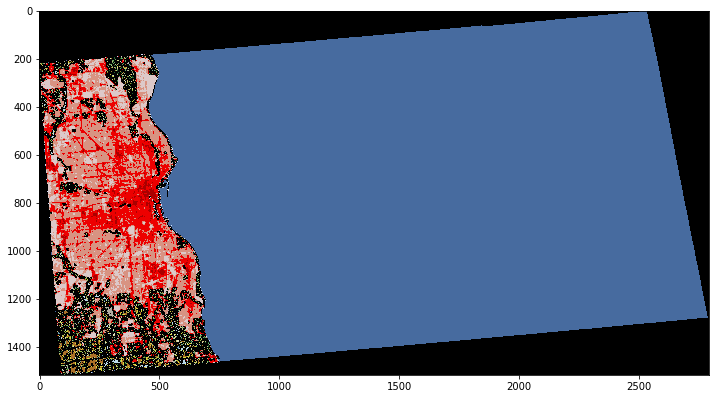

In [17]:
#q13
# How does Milwaukee County look?
fig, ax = plt.subplots(figsize=(12,12))

c = np.zeros((256,3))
c[0] = [0.00000000000, 0.00000000000, 0.00000000000]
c[11] = [0.27843137255, 0.41960784314, 0.62745098039]
c[12] = [0.81960784314, 0.86666666667, 0.97647058824]
c[21] = [0.86666666667, 0.78823529412, 0.78823529412]
c[22] = [0.84705882353, 0.57647058824, 0.50980392157]
c[23] = [0.92941176471, 0.00000000000, 0.00000000000]
c[24] = [0.66666666667, 0.00000000000, 0.00000000000]
c[31] = [0.69803921569, 0.67843137255, 0.63921568628]
c[41] = [0.40784313726, 0.66666666667, 0.38823529412]
c[42] = [0.10980392157, 0.38823529412, 0.18823529412]
c[43] = [0.70980392157, 0.78823529412, 0.55686274510]
c[51] = [0.64705882353, 0.54901960784, 0.18823529412]
c[52] = [0.80000000000, 0.72941176471, 0.48627450980]
c[71] = [0.88627450980, 0.88627450980, 0.75686274510]
c[72] = [0.78823529412, 0.78823529412, 0.46666666667]
c[73] = [0.60000000000, 0.75686274510, 0.27843137255]
c[74] = [0.46666666667, 0.67843137255, 0.57647058824]
c[81] = [0.85882352941, 0.84705882353, 0.23921568628]
c[82] = [0.66666666667, 0.43921568628, 0.15686274510]
c[90] = [0.72941176471, 0.84705882353, 0.91764705882]
c[95] = [0.43921568628, 0.63921568628, 0.72941176471]
custom_cmap = ListedColormap(c)

land = rasterio.open("zip://../p6/land.zip!wi.tif")
window = gpd.GeoSeries([data.loc[15,'geometry']]).set_crs("epsg:4326").to_crs(land.crs)
matrix,_ = mask(land, window, crop=True)
matrix = matrix[0]
ax.imshow(matrix, vmin=0, vmax=255, cmap = custom_cmap)

In [18]:
#q14
# What portion of Milwaukee County is "Open Water"?
open_water_matrix = matrix==11
count = open_water_matrix.astype(int).sum() 
# notice:NOT TO COUNT 0 CELL!!!!!!
total = (matrix!=0).astype(int).sum()   
q14_res = count/total
q14_res

0.7963037455950543

In [19]:
open_water_data = []
for i in range(len(data)):
    window = gpd.GeoSeries([data.loc[i,'geometry']]).set_crs("epsg:4326").to_crs(land.crs)
    matrix,_ = mask(land, window, crop=True)
    matrix = matrix[0]
    open_water_matrix = matrix==11
    count = open_water_matrix.astype(int).sum() 
    open_water_data.append(count)
    
open_water_data    

[1320092,
 14573,
 47659,
 52947,
 2540180,
 70249,
 407817,
 71261,
 46214,
 44972,
 1388303,
 122876,
 92747,
 161618,
 98571,
 2725860,
 50036,
 108618,
 418438,
 265182,
 91255,
 30048,
 31865,
 62625,
 110210,
 22428,
 35576,
 96573,
 469575,
 18722,
 19528,
 74139,
 330635,
 30539,
 43752,
 37132,
 2175794,
 24818,
 429510,
 3706,
 81554,
 43951,
 39155,
 2598589,
 91284,
 79636,
 91988,
 3578,
 17073,
 432970,
 47286,
 16374,
 1623389,
 3599902,
 492274,
 76578,
 5424296,
 77714,
 2132014,
 118197,
 72761,
 224273,
 22580,
 63719,
 244485,
 127124,
 39489,
 130214,
 20409,
 9211,
 74559,
 39553]

Text(0, 0.5, 'POP')

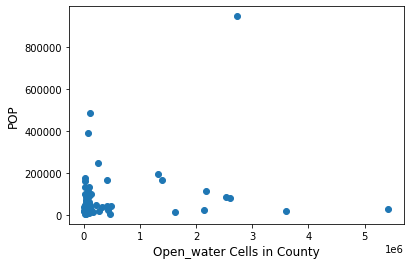

In [20]:
#q15
# What is the Relationship Between POP100 and open_water?
data["POP100"]
plt.scatter(open_water_data,data["POP100"])
plt.xlabel("Open_water Cells in County", fontsize=12)
plt.ylabel("POP", fontsize=12)

In [21]:

tract = gpd.read_file("tracts.geojson")
tract

# get features 
open_water_feature = []
for i in range(len(tract)):
    window = gpd.GeoSeries([tract.loc[i,'geometry']]).set_crs("epsg:4326").to_crs(land.crs)
    matrix,_ = mask(land, window, crop=True)
    matrix = matrix[0]
    temp = matrix==11
    count = temp.astype(int).sum() 
    open_water_feature.append(count)

developed_high = []
for i in range(len(tract)):
    window = gpd.GeoSeries([tract.loc[i,'geometry']]).set_crs("epsg:4326").to_crs(land.crs)
    matrix,_ = mask(land, window, crop=True)
    matrix = matrix[0]
    temp = matrix==24
    count = temp.astype(int).sum() 
    developed_high.append(count)

developed_open = []
for i in range(len(tract)):
    window = gpd.GeoSeries([tract.loc[i,'geometry']]).set_crs("epsg:4326").to_crs(land.crs)
    matrix,_ = mask(land, window, crop=True)
    matrix = matrix[0]
    temp = matrix==21
    count = temp.astype(int).sum() 
    developed_open.append(count)
    
developed_low = []
for i in range(len(tract)):
    window = gpd.GeoSeries([tract.loc[i,'geometry']]).set_crs("epsg:4326").to_crs(land.crs)
    matrix,_ = mask(land, window, crop=True)
    matrix = matrix[0]
    temp = matrix==22
    count = temp.astype(int).sum() 
    developed_low.append(count)

grassland = []
for i in range(len(tract)):
    window = gpd.GeoSeries([tract.loc[i,'geometry']]).set_crs("epsg:4326").to_crs(land.crs)
    matrix,_ = mask(land, window, crop=True)
    matrix = matrix[0]
    temp = matrix==71
    count = temp.astype(int).sum() 
    grassland.append(count)
    


In [22]:
# add features columns to geodataframe
tract["open_water_feature"] = open_water_feature
tract["developed_high"] = developed_high
tract["developed_open"] = developed_open
tract["developed_low"] = developed_low
tract["grassland"] = grassland

Text(0, 0.5, 'R^2 Score')

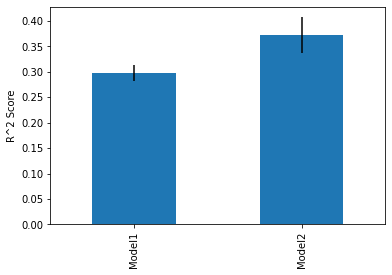

In [23]:
#q16
# How do the models you selected compare under cross validation?
train, test = train_test_split(tract, random_state=320, test_size=0.25)
model1 = LinearRegression()   
model2 = Pipeline([
    ("poly", PolynomialFeatures(include_bias=False)),
    ("lr", LinearRegression()),
])


xcols = ['open_water_feature', 'developed_high','developed_open','developed_low','grassland']

scores1 = cross_val_score(model1, train[xcols], train["POP100"])
scores2 = cross_val_score(model2, train[xcols], train["POP100"])

avg = pd.Series({"Model1": scores1.mean(), "Model2": scores2.mean()})
std = pd.Series({"Model1": scores1.std(), "Model2": scores2.std()})
ax = avg.plot.bar(yerr=std)
ax.set_ylabel("R^2 Score")


In [1]:
#q17
# How does your recommended model score against the test dataset?

# Answer: I would recommend the second model, since it has higher explained variance
model2.fit(train[xcols], train["POP100"])
model2.score(test[xcols], test["POP100"])

NameError: name 'model2' is not defined